# Binary and Multiclass Classification

## Multiclass Classification:

In [1]:
# import the required pacakges, here I have started out with h2o as it is the primary package used in this assignment
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import matplotlib.pyplot as plt

Set up some parameters for the analysis.  

In [2]:
# Defining variables to be used
data_path=None
all_variables=None
test_path=None
target=None
nthreads=1 
min_mem_size=6 
run_time=333
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0 

In [3]:
# Defining helper functions to guide me through the tasks

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(run_id,analysis,target,run_time,classification,scale,model,balance,balance_threshold,name,nthreads,min_mem_size):
  m_data={}
  m_data['run_id'] =run_id
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [4]:
# path to the dataset
data_path='D:/NEU/Courses/BDIA/Assignments/Assignment 2/Data/mobile-price-classification/train.csv'

In [5]:
data_path = os.path.join(os.path.abspath(os.curdir),data_path)

In [6]:
all_variables=None

In [7]:
run_id=alphabet(9)
# run_id to std out
print (run_id) 

Bmhmm0D1Y


In [8]:
#make a folder in the current directory
server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir) 

In [9]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
#h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)
h2o.init(port=port_no)

Checking whether there is an H2O instance running at http://localhost:13409..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from C:\Users\Dhruv Patel\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\DHRUVP~1\AppData\Local\Temp\tmpl0z68lx3
  JVM stdout: C:\Users\DHRUVP~1\AppData\Local\Temp\tmpl0z68lx3\h2o_Dhruv_Patel_started_from_python.out
  JVM stderr: C:\Users\DHRUVP~1\AppData\Local\Temp\tmpl0z68lx3\h2o_Dhruv_Patel_started_from_python.err
  Server is running at http://127.0.0.1:13409
Connecting to H2O server at http://127.0.0.1:13409... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,1 month and 11 days
H2O cluster name:,H2O_from_python_Dhruv_Patel_nrnlka
H2O cluster total nodes:,1
H2O cluster free memory:,3.528 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [10]:
# meta data
meta_data = set_meta_data(run_id,analysis,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,nthreads,min_mem_size)
print(meta_data)  

{'run_id': 'Bmhmm0D1Y', 'start_time': 1541117432.3112383, 'target': None, 'max_models': 9, 'run_time': 333, 'scale': False, 'classification': False, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1541117432.3112383, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [11]:
print(data_path)

D:/NEU/Courses/BDIA/Assignments/Assignment 2/Data/mobile-price-classification/train.csv


In [12]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
df.head()

battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1
1859,0,0.5,1,3,0,22,0.7,164,1,7,1004,1654,1067,17,1,10,1,0,0,1
1821,0,1.7,0,4,1,10,0.8,139,8,10,381,1018,3220,13,8,18,1,0,1,3
1954,0,0.5,1,0,0,24,0.8,187,4,0,512,1149,700,16,3,5,1,1,1,0
1445,1,0.5,0,0,0,53,0.7,174,7,14,386,836,1099,17,1,20,1,0,0,0
509,1,0.6,1,2,1,9,0.1,93,5,15,1137,1224,513,19,10,12,1,0,0,0


In [14]:
df.describe()

Rows:2000
Cols:21




,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
type,int,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,501.0,0.0,0.5,0.0,0.0,0.0,2.0,0.1,80.0,1.0,0.0,0.0,500.0,256.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0
mean,1238.5185,0.495,1.52225,0.5095,4.3095,0.5215,32.046499999999995,0.50175,140.249,4.5205,9.9165,645.108,1251.5155,2124.213,12.3065,5.767,11.011,0.7615,0.503,0.507,1.5
maxs,1998.0,1.0,3.0,1.0,19.0,1.0,64.0,1.0,200.0,8.0,20.0,1960.0,1998.0,3998.0,19.0,18.0,20.0,1.0,1.0,1.0,3.0
sigma,439.41820608353135,0.5001000400170075,0.8160042088950689,0.500034766175005,4.341443747983894,0.49966246736236386,18.14571495520686,0.2884155496235116,35.399654896388355,2.2878367180426604,6.064314941347781,443.7808108064385,432.19944694633796,1084.7320436099494,4.213245004356305,4.3563976058264045,5.463955197766688,0.42627292231873126,0.500116044562674,0.5000760322381083,1.1183136021064612
zeros,0,1010,0,981,474,957,0,0,0,0,101,2,0,0,0,180,0,477,994,986,500
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,842.0,0.0,2.2,0.0,1.0,0.0,7.0,0.6,188.0,2.0,2.0,20.0,756.0,2549.0,9.0,7.0,19.0,0.0,0.0,1.0,1.0
1,1021.0,1.0,0.5,1.0,0.0,1.0,53.0,0.7,136.0,3.0,6.0,905.0,1988.0,2631.0,17.0,3.0,7.0,1.0,1.0,0.0,2.0
2,563.0,1.0,0.5,1.0,2.0,1.0,41.0,0.9,145.0,5.0,6.0,1263.0,1716.0,2603.0,11.0,2.0,9.0,1.0,1.0,0.0,2.0


describe()[source]
Generate an in-depth description of this H2OFrame.

The description is a tabular print of the type, min, max, sigma, number of zeros, and number of missing elements for each H2OVec in this H2OFrame.

Returns:	None (print to stdout) 

In [15]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
  target=df.columns[9]   
y = target

In [16]:
print(y)

n_cores


In [17]:
print(all_variables)

None


In [18]:
if all_variables is not None:
  ivd=get_all_variables_csv(all_variables)
  print(ivd)    
  X=check_all_variables(df,ivd,y)
  print(X)

In [19]:
df.describe()

Rows:2000
Cols:21




,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
type,int,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,501.0,0.0,0.5,0.0,0.0,0.0,2.0,0.1,80.0,1.0,0.0,0.0,500.0,256.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0
mean,1238.5185,0.495,1.52225,0.5095,4.3095,0.5215,32.046499999999995,0.50175,140.249,4.5205,9.9165,645.108,1251.5155,2124.213,12.3065,5.767,11.011,0.7615,0.503,0.507,1.5
maxs,1998.0,1.0,3.0,1.0,19.0,1.0,64.0,1.0,200.0,8.0,20.0,1960.0,1998.0,3998.0,19.0,18.0,20.0,1.0,1.0,1.0,3.0
sigma,439.41820608353135,0.5001000400170075,0.8160042088950689,0.500034766175005,4.341443747983894,0.49966246736236386,18.14571495520686,0.2884155496235116,35.399654896388355,2.2878367180426604,6.064314941347781,443.7808108064385,432.19944694633796,1084.7320436099494,4.213245004356305,4.3563976058264045,5.463955197766688,0.42627292231873126,0.500116044562674,0.5000760322381083,1.1183136021064612
zeros,0,1010,0,981,474,957,0,0,0,0,101,2,0,0,0,180,0,477,994,986,500
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,842.0,0.0,2.2,0.0,1.0,0.0,7.0,0.6,188.0,2.0,2.0,20.0,756.0,2549.0,9.0,7.0,19.0,0.0,0.0,1.0,1.0
1,1021.0,1.0,0.5,1.0,0.0,1.0,53.0,0.7,136.0,3.0,6.0,905.0,1988.0,2631.0,17.0,3.0,7.0,1.0,1.0,0.0,2.0
2,563.0,1.0,0.5,1.0,2.0,1.0,41.0,0.9,145.0,5.0,6.0,1263.0,1716.0,2603.0,11.0,2.0,9.0,1.0,1.0,0.0,2.0


In [20]:
# independent variables

X = []  
if all_variables is None:
  X=get_independent_variables(df, target)  
else: 
  ivd=get_all_variables_csv(all_variables)    
  X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [21]:
# Conditions to find whether a particular type of classofications is true or false
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [22]:
print(classification)

False


In [23]:
# Force target to be factors
# Only 'int' or 'string' are allowed for asfactor(), got Target (Total orders):real 

if classification:
    df[y] = df[y].asfactor()

In [24]:
# Function to check the type of variable
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok, val   

In [25]:
ok,val=check_y(y,df)

In [26]:
print(val)

int


In [27]:
print(ok)

True


In [28]:
if val=='enum':
    print(df[y].levels())

In [29]:
df.describe()

Rows:2000
Cols:21




,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
type,int,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,501.0,0.0,0.5,0.0,0.0,0.0,2.0,0.1,80.0,1.0,0.0,0.0,500.0,256.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0
mean,1238.5185,0.495,1.52225,0.5095,4.3095,0.5215,32.046499999999995,0.50175,140.249,4.5205,9.9165,645.108,1251.5155,2124.213,12.3065,5.767,11.011,0.7615,0.503,0.507,1.5
maxs,1998.0,1.0,3.0,1.0,19.0,1.0,64.0,1.0,200.0,8.0,20.0,1960.0,1998.0,3998.0,19.0,18.0,20.0,1.0,1.0,1.0,3.0
sigma,439.41820608353135,0.5001000400170075,0.8160042088950689,0.500034766175005,4.341443747983894,0.49966246736236386,18.14571495520686,0.2884155496235116,35.399654896388355,2.2878367180426604,6.064314941347781,443.7808108064385,432.19944694633796,1084.7320436099494,4.213245004356305,4.3563976058264045,5.463955197766688,0.42627292231873126,0.500116044562674,0.5000760322381083,1.1183136021064612
zeros,0,1010,0,981,474,957,0,0,0,0,101,2,0,0,0,180,0,477,994,986,500
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,842.0,0.0,2.2,0.0,1.0,0.0,7.0,0.6,188.0,2.0,2.0,20.0,756.0,2549.0,9.0,7.0,19.0,0.0,0.0,1.0,1.0
1,1021.0,1.0,0.5,1.0,0.0,1.0,53.0,0.7,136.0,3.0,6.0,905.0,1988.0,2631.0,17.0,3.0,7.0,1.0,1.0,0.0,2.0
2,563.0,1.0,0.5,1.0,2.0,1.0,41.0,0.9,145.0,5.0,6.0,1263.0,1716.0,2603.0,11.0,2.0,9.0,1.0,1.0,0.0,2.0


In [30]:
allV=get_variables_types(df)
allV

{'battery_power': 'int',
 'blue': 'int',
 'clock_speed': 'real',
 'dual_sim': 'int',
 'fc': 'int',
 'four_g': 'int',
 'int_memory': 'int',
 'm_dep': 'real',
 'mobile_wt': 'int',
 'n_cores': 'int',
 'pc': 'int',
 'price_range': 'int',
 'px_height': 'int',
 'px_width': 'int',
 'ram': 'int',
 'sc_h': 'int',
 'sc_w': 'int',
 'talk_time': 'int',
 'three_g': 'int',
 'touch_screen': 'int',
 'wifi': 'int'}

In [31]:
meta_data['variables']=allV

In [32]:
# split into training and test for showing how to predict
train, test = df.split_frame([0.9])

In [33]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [34]:
model_start_time = time.time()

In [35]:
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [36]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [37]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [38]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_AllModels_0_AutoML_20181101_20...,5.230330,2.286992,5.230330,1.986784,0.491947
1,StackedEnsemble_BestOfFamily_0_AutoML_20181101...,5.233554,2.287696,5.233554,1.987172,0.492065
2,GLM_grid_0_AutoML_20181101_201034_model_0,5.240967,2.289316,5.240967,1.987737,0.492339
3,GBM_grid_0_AutoML_20181101_201034_model_14,5.242659,2.289685,5.242659,1.988745,0.492393
4,GBM_grid_0_AutoML_20181101_201034_model_9,5.249302,2.291136,5.249302,1.988418,0.492536
5,GBM_grid_0_AutoML_20181101_201034_model_6,5.265794,2.294732,5.265794,1.988011,0.492587
6,GBM_grid_0_AutoML_20181101_201034_model_5,5.270891,2.295842,5.270891,1.983603,0.493013
7,GBM_grid_0_AutoML_20181101_201034_model_4,5.359543,2.315069,5.359543,1.993779,0.496374
8,GBM_grid_0_AutoML_20181101_201034_model_8,5.379979,2.319478,5.379979,1.997787,0.496741
9,DeepLearning_0_AutoML_20181101_201034,5.491209,2.343333,5.491209,2.021560,0.504557


In [39]:
# Start best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [40]:
mod_best._id

'StackedEnsemble_AllModels_0_AutoML_20181101_201034'

In [41]:
# Get stacked ensemble  
se=get_stacked_ensemble(model_set)

In [42]:
print(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181101_201034


In [43]:
if se is not None:
  mod_best=h2o.get_model(se)

In [44]:
# best model on teh leaderboard
mod_best._id

'StackedEnsemble_BestOfFamily_0_AutoML_20181101_201034'

In [45]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics>

In [46]:
type(mod_best)

h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator

In [47]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181101_201034
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 5.230147653735896
RMSE: 2.2869516072133873
MAE: 1.986684600432603
RMSLE: 0.4919324883880607
R^2: 2.220446049250313e-16
Mean Residual Deviance: 5.230147653735896
Null degrees of freedom: 1460
Residual degrees of freedom: 1460
Null deviance: 7641.245722108145
Residual deviance: 7641.245722108145
AIC: 6567.274517769078

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 5.153677371303064
RMSE: 2.27017122070188
MAE: 1.985808033349188
RMSLE: 0.48229723025969107
R^2: -0.0012499123488676211
Mean Residual Deviance: 5.153677371303064
Null degrees of freedom: 353
Residual degrees of freedom: 353
Null deviance: 1824.4017894412846
Residual deviance: 1824.4017894412846
AIC: 1589.0660029486096

ModelMetricsRegressionGLM: stackeden

In [48]:
bm=stackedensemble_df(aml_leaderboard_df)

In [49]:
bm

['GBM_grid_0_AutoML_20181101_201034_model_14',
 'GLM_grid_0_AutoML_20181101_201034_model_0',
 'DRF_0_AutoML_20181101_201034',
 'XRT_0_AutoML_20181101_201034',
 'DeepLearning_0_AutoML_20181101_201034']

In [50]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_AllModels_0_AutoML_20181101_20...,5.230330,2.286992,5.230330,1.986784,0.491947
1,StackedEnsemble_BestOfFamily_0_AutoML_20181101...,5.233554,2.287696,5.233554,1.987172,0.492065
2,GLM_grid_0_AutoML_20181101_201034_model_0,5.240967,2.289316,5.240967,1.987737,0.492339
3,GBM_grid_0_AutoML_20181101_201034_model_14,5.242659,2.289685,5.242659,1.988745,0.492393
4,GBM_grid_0_AutoML_20181101_201034_model_9,5.249302,2.291136,5.249302,1.988418,0.492536
5,GBM_grid_0_AutoML_20181101_201034_model_6,5.265794,2.294732,5.265794,1.988011,0.492587
6,GBM_grid_0_AutoML_20181101_201034_model_5,5.270891,2.295842,5.270891,1.983603,0.493013
7,GBM_grid_0_AutoML_20181101_201034_model_4,5.359543,2.315069,5.359543,1.993779,0.496374
8,GBM_grid_0_AutoML_20181101_201034_model_8,5.379979,2.319478,5.379979,1.997787,0.496741
9,DeepLearning_0_AutoML_20181101_201034,5.491209,2.343333,5.491209,2.021560,0.504557


In [51]:
#  Get best_models and coef_norm()
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
  if 'Intercept' in best_models.keys():
    del best_models['Intercept']
  bm=list(best_models.keys())
else:
  best_models={}
  bm=stackedensemble_df(aml_leaderboard_df)   
  for b in bm:   
    best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [52]:
bm

['GLM_grid_0_AutoML_20181101_201034_model_0',
 'GBM_grid_0_AutoML_20181101_201034_model_14',
 'DeepLearning_0_AutoML_20181101_201034',
 'DRF_0_AutoML_20181101_201034',
 'XRT_0_AutoML_20181101_201034',
 'StackedEnsemble_BestOfFamily_0_AutoML_20181101_201034']

In [53]:
# Best of Family leaderboard

aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]


In [54]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
1,StackedEnsemble_BestOfFamily_0_AutoML_20181101...,5.233554,2.287696,5.233554,1.987172,0.492065
2,GLM_grid_0_AutoML_20181101_201034_model_0,5.240967,2.289316,5.240967,1.987737,0.492339
3,GBM_grid_0_AutoML_20181101_201034_model_14,5.242659,2.289685,5.242659,1.988745,0.492393
9,DeepLearning_0_AutoML_20181101_201034,5.491209,2.343333,5.491209,2.021560,0.504557
16,DRF_0_AutoML_20181101_201034,5.906617,2.430353,5.906617,2.074948,0.513222
17,XRT_0_AutoML_20181101_201034,6.012143,2.451967,6.012143,2.082894,0.517068


In [55]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [56]:
# First model of the leaderboard
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

StackedEnsemble_BestOfFamily_0_AutoML_20181101_201034


In [57]:
mod_best=h2o.get_model(top)
print(mod_best._id)
print(mod_best.algo)

StackedEnsemble_BestOfFamily_0_AutoML_20181101_201034
stackedensemble


In [58]:

meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

In [59]:
meta_data['models']=bm

In [60]:
# Saving the models in a folder in the current directory
models_path=os.path.join(run_dir,'models')
for mod in bm:
  try:   
    m=h2o.get_model(mod) 
    h2o.save_model(m, path = models_path)
  except:    
    pass    

In [61]:
print(models_path)

D:\NEU\Courses\BDIA\Assignments\Assignment 2\Bmhmm0D1Y\models


In [62]:
# GBM
 
mod,mod_id=get_model_by_algo("GBM",best_models)
if mod is not None:
    try:     
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
    except:
        pass   
    try:     
        stats_gbm={}
        stats_gbm=gbm_stats(mod)
        n=run_id+'_gbm_stats.json'
        dict_to_json(stats_gbm,n)
        print(stats_gbm)
    except:
        pass        

{'algo': 'gbm', 'model_id': 'GBM_grid_0_AutoML_20181101_201034_model_14', 'varimp': [('battery_power', 2622.55517578125, 1.0, 0.13315616956464751), ('ram', 2003.3814697265625, 0.7639044120891612, 0.10171858542732672), ('sc_w', 1553.2181396484375, 0.5922537508427212, 0.0788622408725119), ('px_height', 1390.4974365234375, 0.5302071237106435, 0.07060034966919848), ('mobile_wt', 1314.431884765625, 0.5012027571065537, 0.06673823931154911), ('sc_h', 1280.5687255859375, 0.4882904799913163, 0.06501888995052685), ('clock_speed', 1249.46435546875, 0.4764301498810369, 0.06343961382326978), ('pc', 1214.8834228515625, 0.4632441803591999, 0.06168382062974578), ('talk_time', 1207.4398193359375, 0.4604058783915749, 0.061305883211669035), ('int_memory', 1193.6595458984375, 0.4551513565554824, 0.06060621121108115), ('px_width', 1102.2724609375, 0.42030477418235324, 0.05596617377985631), ('m_dep', 684.5672607421875, 0.2610306418198646, 0.03475784040373466), ('fc', 646.0120849609375, 0.24632926350862866, 

In [63]:
# DeepLearning

mod,mod_id=get_model_by_algo("Dee",best_models)


In [64]:
if mod is not None:
    try:    
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
    except:
        pass 
    try:
        stats_dl={}
        stats_dl=dl_stats(mod)
        n=run_id+'_dl_stats.json'
        dict_to_json(stats_dl,n)
        print(stats_dl)
    except:
        pass    
    try:
        cf=mod.confusion_matrix()    
        cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
    except:
        pass       

{'algo': 'deeplearning', 'model_id': 'DeepLearning_0_AutoML_20181101_201034', 'varimp': [('ram', 1.0, 1.0, 0.06607766104365496), ('fc', 0.9324526786804199, 0.9324526786804199, 0.0616142920410929), ('sc_h', 0.8340643048286438, 0.8340643048286438, 0.05511301842307883), ('m_dep', 0.8264710903167725, 0.8264710903167725, 0.05461127656833164), ('mobile_wt', 0.819875180721283, 0.819875180721283, 0.05417543428980629), ('pc', 0.8075678944587708, 0.8075678944587708, 0.05336219759978478), ('int_memory', 0.7956767678260803, 0.7956767678260803, 0.05257645976472268), ('three_g', 0.7794851660728455, 0.7794851660728455, 0.05150655659231858), ('px_height', 0.7739356160163879, 0.7739356160163879, 0.05113985530474318), ('wifi', 0.7736800909042358, 0.7736800909042358, 0.05112297080299425), ('price_range', 0.7695082426071167, 0.7695082426071167, 0.050847304825291664), ('talk_time', 0.7518985271453857, 0.7518985271453857, 0.049683696015936196), ('touch_screen', 0.743182361125946, 0.743182361125946, 0.049107

In [65]:
# DRF

mod,mod_id=get_model_by_algo("DRF",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_drf_scoring_history.csv') 
    except:
         pass  
    try: 
         stats_drf={}
         stats_drf=drf_stats(mod)
         n=run_id+'_drf_stats.json'
         dict_to_json(stats_drf,n)
         print(stats_drf)
    except:
         pass     

In [66]:
# XRT

mod,mod_id=get_model_by_algo("XRT",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_xrt_scoring_history.csv')
    except:
         pass     
    try:        
         stats_xrt={}
         stats_xrt=xrt_stats(mod)
         n=run_id+'_xrt_stats.json'
         dict_to_json(stats_xrt,n)
         print(stats_xrt)
    except:
         pass     

In [67]:
# GLM

mod,mod_id=get_model_by_algo("GLM",best_models)
if mod is not None:
    try:     
         stats_glm={}
         stats_glm=glm_stats(mod)
         n=run_id+'_glm_stats.json'
         dict_to_json(stats_glm,n)
         print(stats_glm)
    except:
         pass     

{'algo': 'glm', 'model_id': 'GLM_grid_0_AutoML_20181101_201034_model_0', 'coef': {'Intercept': 4.519840073387449, 'battery_power': -2.726747694076588e-05, 'blue': 0.028666557881362357, 'clock_speed': -0.003096373834952003, 'dual_sim': -0.01624495848685264, 'fc': -0.0008026042036447989, 'four_g': -0.01693469527579419, 'int_memory': -0.00023127505052926455, 'm_dep': 0.0060482510855106916, 'mobile_wt': -0.00010523369542809849, 'pc': 0.0015442311162590532, 'px_height': -1.3052428013223182e-06, 'px_width': -6.680072016893093e-06, 'ram': 6.172477649220337e-07, 'sc_h': 0.0013771302665676443, 'sc_w': 0.0026910510480300624, 'talk_time': 0.0008757615664837694, 'three_g': -0.0037521835334685663, 'touch_screen': 0.010611037654654844, 'wifi': -0.005705404645218696, 'price_range': -0.0022039528601205992}, 'coef_norm': {'Intercept': 4.501711156741957, 'battery_power': -0.01197632817991355, 'blue': 0.014337914704977065, 'clock_speed': -0.0025122233953232594, 'dual_sim': -0.008124832184843268, 'fc': -0

In [68]:
# Making the predictions:
predictions_df=predictions_test(mod_best,test,run_id)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [69]:
predictions_df.head()

predict
4.50171
4.50171
4.50171
4.50171
4.50171
4.50171
4.50171
4.50171
4.50171
4.50171


In [70]:
predictions_df.describe()

Rows:185
Cols:1




,predict
type,real
mins,4.501711156741957
mean,4.501711156741957
maxs,4.501711156741957
sigma,0.0
zeros,0
missing,0
0,4.501711156741957
1,4.501711156741957
2,4.501711156741957


In [71]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)    


In [72]:
meta_data

{'X': ['battery_power',
  'blue',
  'dual_sim',
  'fc',
  'four_g',
  'int_memory',
  'mobile_wt',
  'pc',
  'px_height',
  'px_width',
  'ram',
  'sc_h',
  'sc_w',
  'talk_time',
  'three_g',
  'touch_screen',
  'wifi',
  'price_range',
  'clock_speed',
  'm_dep'],
 'analysis': 0,
 'balance': False,
 'balance_threshold': 0.2,
 'classification': False,
 'end_time': 1541117773.9641595,
 'execution_time': 341.6529211997986,
 'max_models': 9,
 'min_mem_size': 6,
 'mod_best': 'StackedEnsemble_BestOfFamily_0_AutoML_20181101_201034',
 'mod_best_algo': 'stackedensemble',
 'model_execution_time': 338.6958763599396,
 'models': ['GLM_grid_0_AutoML_20181101_201034_model_0',
  'GBM_grid_0_AutoML_20181101_201034_model_14',
  'DeepLearning_0_AutoML_20181101_201034',
  'DRF_0_AutoML_20181101_201034',
  'XRT_0_AutoML_20181101_201034',
  'StackedEnsemble_BestOfFamily_0_AutoML_20181101_201034'],
 'nthreads': 1,
 'project': None,
 'run_id': 'Bmhmm0D1Y',
 'run_time': 333,
 'scale': False,
 'start_time': 1

#### Plotting the graphs:

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


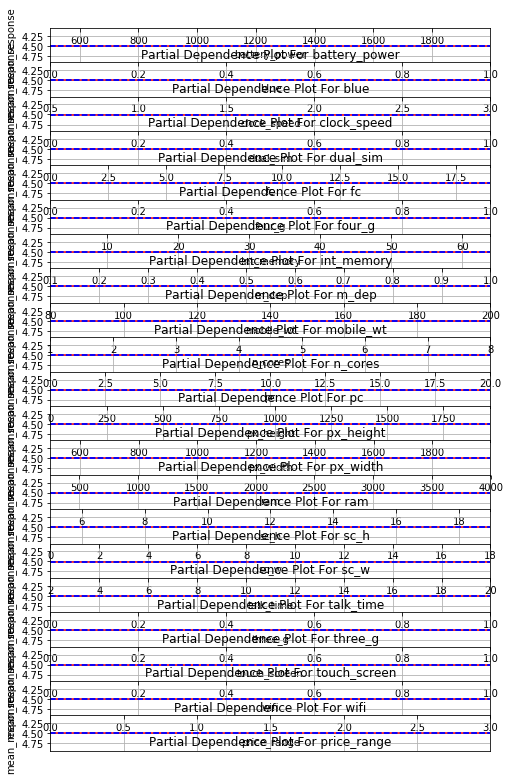

In [74]:
aml.leader.partial_plot(data=df, cols=df.columns)
plt.show()

In [75]:
x = df.columns
y = 'n_cores'

In [77]:
splits = df.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

In [78]:
print(train.nrow)
print(valid.nrow)
print(test.nrow)

1418
275
307


## GLM: 

In [79]:
# Import H2O GLM:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [80]:
# Initialize the GLM estimator:
# Similar to R's glm() and H2O's R GLM, H2O's GLM has the "family" argument

glm_fit1 = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit1')

In [81]:
glm_fit1.train(x=x, y=y, training_frame=train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [92]:
glm_fit2 = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit2', lambda_search=True)
glm_fit2.train(x=x, y=y, training_frame=train, validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [93]:
glm_perf1 = glm_fit1.model_performance(test)
glm_perf2 = glm_fit2.model_performance(test)

In [94]:
# Print model performance
print(glm_perf1)
print(glm_perf2)


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2502688688198629
RMSE: 0.5002687965682677
LogLoss: 0.6937689209718814
Null degrees of freedom: 306
Residual degrees of freedom: 286
Null deviance: 424.8774043897665
Residual deviance: 425.97411747673516
AIC: 467.97411747673516
AUC: 0.5326947637292465
Gini: 0.06538952745849302
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3621378681275394: 


,0,1,Error,Rate
0,0.0,145.0,1.0,(145.0/145.0)
1,0.0,162.0,0.0,(0.0/162.0)
Total,0.0,307.0,0.4723,(145.0/307.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3621379,0.6908316,306.0
max f2,0.3621379,0.8481675,306.0
max f0point5,0.4594057,0.5866900,244.0
max accuracy,0.4594057,0.5472313,244.0
max precision,0.6421577,1.0,0.0
max recall,0.3621379,1.0,306.0
max specificity,0.6421577,1.0,0.0
max absolute_mcc,0.4141130,0.1236286,291.0
max min_per_class_accuracy,0.5044044,0.5246914,152.0
max mean_per_class_accuracy,0.5151368,0.5476373,133.0


Gains/Lift Table: Avg response rate: 52.77 %, avg score: 50.59 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0130293,0.6190808,0.9475309,0.9475309,0.5,0.6288965,0.5,0.6288965,0.0123457,0.0123457,-5.2469136,-5.2469136
,2,0.0228013,0.6127276,0.6316872,0.8121693,0.3333333,0.6148367,0.4285714,0.6228708,0.0061728,0.0185185,-36.8312757,-18.7830688
,3,0.0325733,0.6012781,1.2633745,0.9475309,0.6666667,0.6046265,0.5,0.6173975,0.0123457,0.0308642,26.3374486,-5.2469136
,4,0.0423453,0.5971542,1.2633745,1.0204179,0.6666667,0.5975439,0.5384615,0.6128159,0.0123457,0.0432099,26.3374486,2.0417854
,5,0.0521173,0.5954325,1.2633745,1.0659722,0.6666667,0.5961029,0.5625,0.6096822,0.0123457,0.0555556,26.3374486,6.5972222
,6,0.1009772,0.5752668,1.2633745,1.1614894,0.6666667,0.5867800,0.6129032,0.5986005,0.0617284,0.1172840,26.3374486,16.1489446
,7,0.1498371,0.5655272,1.3897119,1.2359098,0.7333333,0.5690646,0.6521739,0.5889692,0.0679012,0.1851852,38.9711934,23.5909823
,8,0.2019544,0.5559563,0.9475309,1.1614894,0.5,0.5608611,0.6129032,0.5817155,0.0493827,0.2345679,-5.2469136,16.1489446
,9,0.2996743,0.5357072,1.0106996,1.1123188,0.5333333,0.5448925,0.5869565,0.5697080,0.0987654,0.3333333,1.0699588,11.2318841
,10,0.4006515,0.5220456,1.0392274,1.0938974,0.5483871,0.5297984,0.5772358,0.5596495,0.1049383,0.4382716,3.9227399,9.3897420





ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25017153135534226
RMSE: 0.500171501942426
LogLoss: 0.6935537752437657
Null degrees of freedom: 306
Residual degrees of freedom: 288
Null deviance: 424.8774043897665
Residual deviance: 425.8420179996721
AIC: 463.8420179996721
AUC: 0.5306087696892294
Gini: 0.06121753937845886
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37348765940378736: 


,0,1,Error,Rate
0,0.0,145.0,1.0,(145.0/145.0)
1,0.0,162.0,0.0,(0.0/162.0)
Total,0.0,307.0,0.4723,(145.0/307.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3734877,0.6908316,306.0
max f2,0.3734877,0.8481675,306.0
max f0point5,0.3734877,0.5827338,306.0
max accuracy,0.4939951,0.5472313,182.0
max precision,0.6262120,1.0,0.0
max recall,0.3734877,1.0,306.0
max specificity,0.6262120,1.0,0.0
max absolute_mcc,0.5501215,0.1253005,62.0
max min_per_class_accuracy,0.5083252,0.5246914,152.0
max mean_per_class_accuracy,0.5501215,0.5506811,62.0


Gains/Lift Table: Avg response rate: 52.77 %, avg score: 50.74 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0130293,0.6057958,0.9475309,0.9475309,0.5,0.6140879,0.5,0.6140879,0.0123457,0.0123457,-5.2469136,-5.2469136
,2,0.0228013,0.5975730,1.2633745,1.0828924,0.6666667,0.6005195,0.5714286,0.6082729,0.0123457,0.0246914,26.3374486,8.2892416
,3,0.0325733,0.5924263,0.6316872,0.9475309,0.3333333,0.5949654,0.5,0.6042807,0.0061728,0.0308642,-36.8312757,-5.2469136
,4,0.0423453,0.5898865,0.6316872,0.8746439,0.3333333,0.5907425,0.4615385,0.6011565,0.0061728,0.0370370,-36.8312757,-12.5356125
,5,0.0521173,0.5881760,1.8950617,1.0659722,1.0,0.5885900,0.5625,0.5988002,0.0185185,0.0555556,89.5061728,6.5972222
,6,0.1009772,0.5682101,1.0106996,1.0392274,0.5333333,0.5796092,0.5483871,0.5895143,0.0493827,0.1049383,1.0699588,3.9227399
,7,0.1498371,0.5615335,1.2633745,1.1123188,0.6666667,0.5654885,0.5869565,0.5816798,0.0617284,0.1666667,26.3374486,11.2318841
,8,0.2019544,0.5501748,1.5397377,1.2226205,0.8125,0.5558224,0.6451613,0.5750069,0.0802469,0.2469136,53.9737654,22.2620470
,9,0.2996743,0.5354211,0.8843621,1.1123188,0.4666667,0.5424700,0.5869565,0.5643970,0.0864198,0.3333333,-11.5637860,11.2318841
,10,0.4006515,0.5222124,0.7947033,1.0322694,0.4193548,0.5284760,0.5447154,0.5553438,0.0802469,0.4135802,-20.5296695,3.2269397


In [95]:
# Retreive test set AUC
print(glm_perf1.auc())
print(glm_perf2.auc())

0.5326947637292465
0.5306087696892294


In [96]:
# Compare test AUC to the training AUC and validation AUC
print(glm_fit2.auc(train=True))
print(glm_fit2.auc(valid=True))

0.5611759154736095
0.5388499149659864


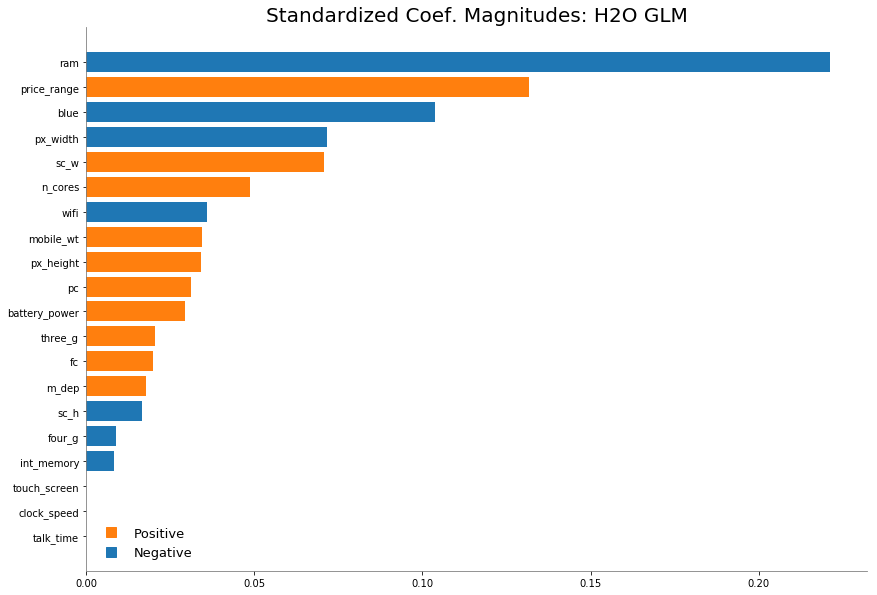

In [97]:
# Standard Coef. Magnitudes
glm_fit2.std_coef_plot()

# RandomForestEstimator

In [88]:
# Import H2O RF:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [89]:
# Initialize the RF estimator:

rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', seed=1)

In [99]:
rf_fit1.train(x=x, y=y, training_frame=train, validation_frame = valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [100]:
rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100, seed=1)
rf_fit2.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [101]:
rf_perf1 = rf_fit1.model_performance(test)
rf_perf2 = rf_fit2.model_performance(test)

In [103]:
rf_fit3 = H2ORandomForestEstimator(model_id='rf_fit3', seed=1, nfolds=5)
rf_fit3.train(x=x, y=y, training_frame=df)

drf Model Build progress: |███████████████████████████████████████████████| 100%


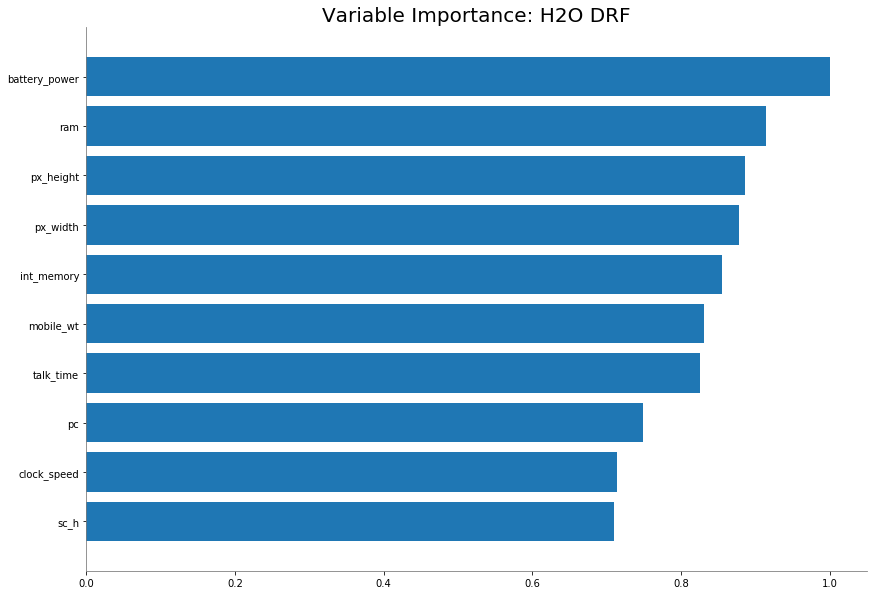

In [105]:
rf_fit2.varimp_plot()

# GradientBoostingEstimator

In [106]:
# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [107]:
# Initialize and train the GBM estimator:

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [108]:
gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit2.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [110]:
# Now let's use early stopping to find optimal ntrees

gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', 
                                        ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        #stopping_metric='AUC',     #used for early stopping
                                        stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

# The use of a validation_frame is recommended with using early stopping
gbm_fit3.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [111]:
gbm_perf1 = gbm_fit1.model_performance(test)
gbm_perf2 = gbm_fit2.model_performance(test)
gbm_perf3 = gbm_fit3.model_performance(test)

In [112]:
#History of the 2nd GBM model
gbm_fit2.scoring_history()

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2018-11-01 20:26:47,0.001 sec,0.0,0.499801,0.499602,0.249801
1,,2018-11-01 20:26:47,0.009 sec,1.0,0.497196,0.496868,0.247204
2,,2018-11-01 20:26:47,0.013 sec,2.0,0.494655,0.494076,0.244684
3,,2018-11-01 20:26:47,0.018 sec,3.0,0.492400,0.491559,0.242458
4,,2018-11-01 20:26:47,0.022 sec,4.0,0.489386,0.488336,0.239498
5,,2018-11-01 20:26:47,0.027 sec,5.0,0.486514,0.485279,0.236696
6,,2018-11-01 20:26:47,0.030 sec,6.0,0.483899,0.482282,0.234159
7,,2018-11-01 20:26:47,0.035 sec,7.0,0.480136,0.478309,0.230530
8,,2018-11-01 20:26:47,0.039 sec,8.0,0.476323,0.474147,0.226884
9,,2018-11-01 20:26:47,0.043 sec,9.0,0.473770,0.471285,0.224458


In [113]:
#History of the 3rd GBM model
gbm_fit3.scoring_history()

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2018-11-01 20:27:07,0.000 sec,0.0,0.499801,0.499602,0.249801
1,,2018-11-01 20:27:07,0.022 sec,5.0,0.486514,0.485279,0.236696
2,,2018-11-01 20:27:07,0.041 sec,10.0,0.469802,0.467131,0.220714
3,,2018-11-01 20:27:07,0.058 sec,15.0,0.456772,0.452381,0.208641
4,,2018-11-01 20:27:07,0.076 sec,20.0,0.441416,0.435480,0.194848
5,,2018-11-01 20:27:07,0.095 sec,25.0,0.425562,0.417822,0.181103
6,,2018-11-01 20:27:07,0.114 sec,30.0,0.417420,0.408665,0.174240
7,,2018-11-01 20:27:07,0.132 sec,35.0,0.406808,0.396519,0.165493
8,,2018-11-01 20:27:07,0.150 sec,40.0,0.397852,0.386353,0.158286
9,,2018-11-01 20:27:07,0.170 sec,45.0,0.388478,0.375711,0.150915


# Deep Learning Estimator

In [115]:
# Import H2O DL:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [116]:
# Initialize and train the DL estimator:
# Here I have used 3 models with varying parameters

#Model 1
dl_fit1 = H2ODeepLearningEstimator(model_id='dl_fit1', seed=1)
dl_fit1.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [117]:
# Model 2
dl_fit2 = H2ODeepLearningEstimator(model_id='dl_fit2', 
                                   epochs=20, 
                                   hidden=[10,10], 
                                   stopping_rounds=0,  #disable early stopping
                                   seed=1)
dl_fit2.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [118]:
# Model 3
dl_fit3 = H2ODeepLearningEstimator(model_id='dl_fit3', 
                                   epochs=20, 
                                   hidden=[10,10],
                                   score_interval=1,          #used for early stopping
                                   stopping_rounds=3,         #used for early stopping
                                   #stopping_metric='AUC',     #used for early stopping
                                   stopping_tolerance=0.0005, #used for early stopping
                                   seed=1)
dl_fit3.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [119]:
dl_perf1 = dl_fit1.model_performance(test)
dl_perf2 = dl_fit2.model_performance(test)
dl_perf3 = dl_fit3.model_performance(test)

In [121]:
dl_fit3.scoring_history()

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2018-11-01 20:27:48,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2018-11-01 20:27:48,0.025 sec,189066 obs/sec,2.0,1,2836.0,0.514182,0.264383,0.492901,-0.058374
2,,2018-11-01 20:27:48,0.135 sec,232459 obs/sec,20.0,10,28360.0,0.478586,0.229045,0.464364,0.083091


## Analysis:

- In this notebook I have performed multiclass classification using h20 where I have defined the variable whose label I have to predict. First I have initialized the h20 instance and and then I have used AutoML to find out various models which are best suitable for predicting my the label of dependent variable.  
- Later I have created a leaderboard to which has a llist of models with the best model at the top.   
- I have used that model and have done various types of analysis on it.   
- I have also plotted graphs for visual representaion.  
- Later using h20, I have applied various algorithms of GLM, Random Forest Classifier, GBM, and Deep Learning Estimator for analysis without using AutoML.